In [1]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import linregress
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import json

import psycopg2
import pandas as pd

import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost, getStatValues,density_plot, get_mdfps,density_plot_multiple
from functools import reduce
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
#disable futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}

In [3]:
long = get_mdfps('one_25ns')
short = get_mdfps('one_5ns')
augmented = get_mdfps('five_5ns')

2986 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
2993 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
11089 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


Plot 1 Stats:
RMSE:  1.3847943863480319
MAE:  0.8624140381722034
R2:  0.8537180390534396
Plot 2 Stats:
RMSE:  1.3722323602349882
MAE:  0.8370897975056282
R2:  0.8560346312953192
Plot 3 Stats:
RMSE:  1.3523095707922415
MAE:  0.7975129968382616
R2:  0.8603239662209498


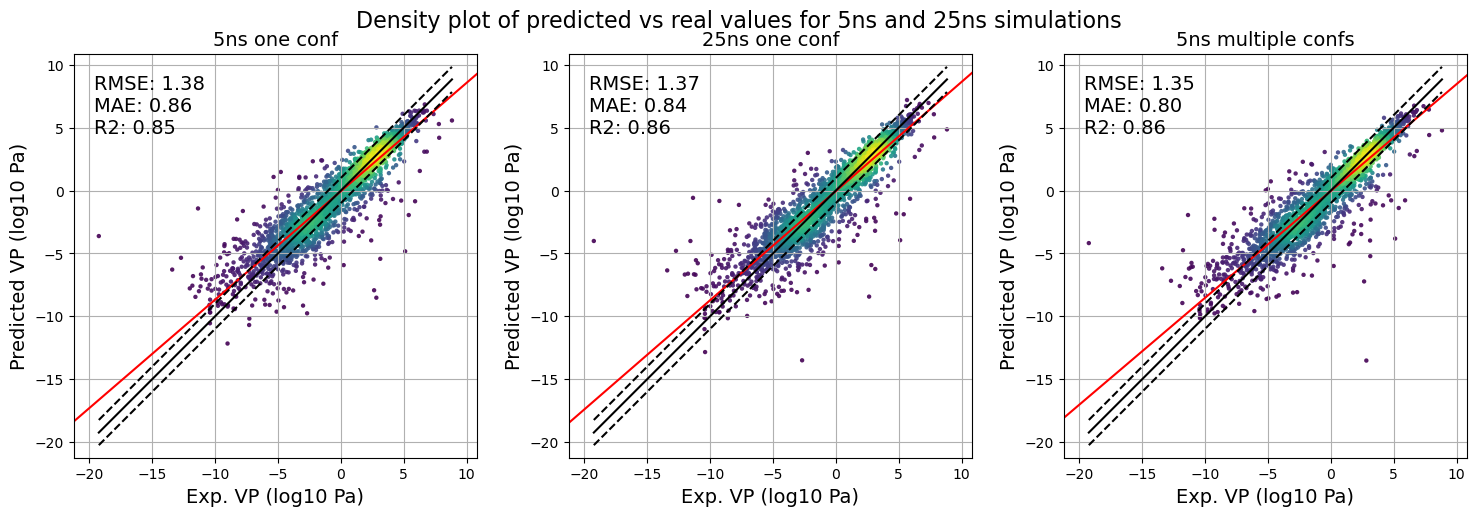

In [8]:
params_standard = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}

params_augmented = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
vps_short_augmented, preds_short_augmented, mrns_short_augmented, confids_short_augmented = train_pred_xgboost(augmented,params = params_augmented,average=True)
vps_short, preds_short, mrns_short, confids_short = train_pred_xgboost(short,params = params)
vps_long, preds_long, mrns_long, confids_long = train_pred_xgboost(long,params = params)
density_plot_multiple(reals=[vps_short,vps_long,vps_short_augmented], predictions=[preds_short,preds_long,preds_short_augmented], titles=['5ns one conf','25ns one conf','5ns multiple confs'], global_title='Density plot of predicted vs real values for 5ns and 25ns simulations')


In [27]:
#make df fro all three, and combine on mrn
df_short = pd.DataFrame({'mrn':mrns_short,'pred':preds_short,'real':vps_short})
df_long = pd.DataFrame({'mrn':mrns_long,'pred':preds_long,'real':vps_long})
df_augmented = pd.DataFrame({'mrn':mrns_short_augmented,'pred':preds_short_augmented,'real':vps_short_augmented })
#remove points that are not in all three
mrns_short = set(df_short['mrn'])
mrns_long = set(df_long['mrn'])
mrns_augmented = set(df_augmented['mrn'])
mrns = mrns_short.intersection(mrns_long).intersection(mrns_augmented)
df_short = df_short[df_short['mrn'].isin(mrns)]
df_long = df_long[df_long['mrn'].isin(mrns)]
df_augmented = df_augmented[df_augmented['mrn'].isin(mrns)]
print(len(df_short),len(df_long),len(df_augmented))


#join on mrno


TypeError: 'set' type is unordered

RMSE:  0.668754557273758
MAE:  0.4395595072848742
R2:  0.6560994912784739


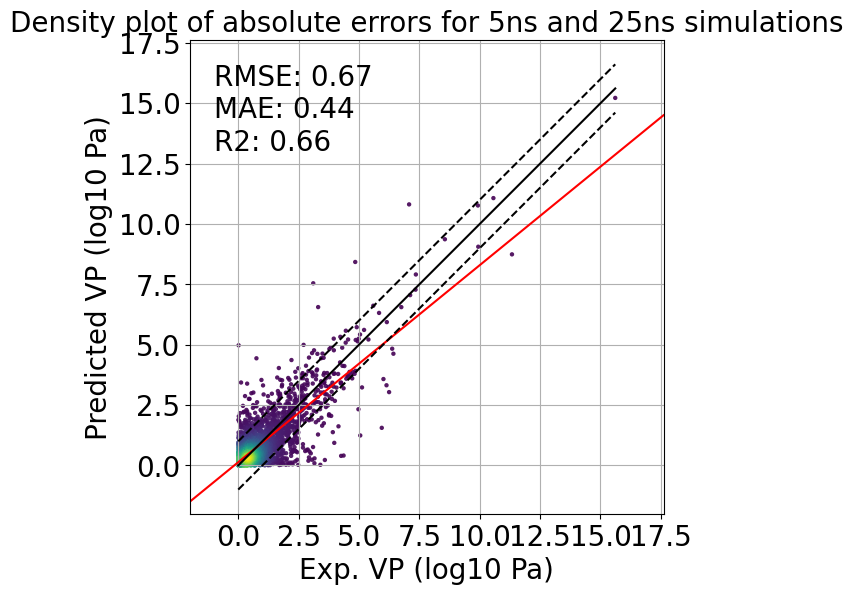

AttributeError: 'NoneType' object has no attribute 'show'

In [37]:
mrnos_augmented = df_augmented['mrn'].tolist()
mrnos_short = df_short['mrn'].tolist()
df_combined = df_short.copy()
#add pred and real from long
#rename pred to pred short
df_combined = df_combined.rename(columns={'pred':'pred_short'})
df_combined['pred_long'] = df_long['pred'].tolist()
df_combined['pred_augmented'] = df_augmented['pred'].tolist()
df_combined
#get abs of all to real
df_combined['abs_error_short'] = abs(df_combined['pred_short'] - df_combined['real'])
df_combined['abs_error_long'] = abs(df_combined['pred_long'] - df_combined['real'])
df_combined['abs_error_augmented'] = abs(df_combined['pred_augmented'] - df_combined['real'])
#sort by abs error short
df_combined = df_combined.sort_values(by=['abs_error_short'],ascending=False)
#plot abs error short vs abs error augmentetd
abs_errors_short = df_combined['abs_error_short'].tolist()
abs_errors_long = df_combined['abs_error_long'].tolist()
plt = density_plot(real=abs_errors_short,prediction=abs_errors_long,title='Density plot of absolute errors for 5ns and 25ns simulations')
plt.show()

In [5]:
#print number of datapoints for each plot
print('5ns one conf',len(vps_short))
print('25ns one conf',len(vps_long))
print('5ns multiple confs',len(vps_short_augmented))

5ns one conf 2993
25ns one conf 2986
5ns multiple confs 2982
